# 04 - Train Baseline Model

In [53]:
# imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

#notebook settings
pd.set_option('display.max_columns', None)

#pipelines
from sklearn.pipeline import Pipeline

# building a pipeline to preprocess the data
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [23]:
data = pd.read_csv(os.path.join('..','data','prepared_football_data.csv'))

data_for_back_testing = data[['market_home_odds','market_draw_odds','market_away_odds','implied_home_win_prob','implied_draw_prob','implied_away_win_prob']]

data = data.drop(columns=['market_home_odds','market_draw_odds','market_away_odds','implied_home_win_prob','implied_draw_prob','implied_away_win_prob'])

print(data.shape)

data.head()

(7320, 137)


,home_team,away_team,full_time_result,day_of_week,month,day_of_week_sin,day_of_week_cos,month_sin,month_cos,home_roll_3_avg_home_total_goals,away_roll_3_avg_home_total_goals,home_roll_3_avg_away_total_goals,away_roll_3_avg_away_total_goals,home_roll_3_avg_home_total_shots,away_roll_3_avg_home_total_shots,home_roll_3_avg_away_total_shots,away_roll_3_avg_away_total_shots,home_roll_3_avg_home_shots_on_target,away_roll_3_avg_home_shots_on_target,home_roll_3_avg_away_shots_on_target,away_roll_3_avg_away_shots_on_target,home_roll_3_avg_home_fouls,away_roll_3_avg_home_fouls,home_roll_3_avg_away_fouls,away_roll_3_avg_away_fouls,home_roll_3_avg_home_corners,away_roll_3_avg_home_corners,home_roll_3_avg_away_corners,away_roll_3_avg_away_corners,home_roll_3_avg_home_yellow_cards,away_roll_3_avg_home_yellow_cards,home_roll_3_avg_away_yellow_cards,away_roll_3_avg_away_yellow_cards,home_roll_3_avg_home_red_cards,away_roll_3_avg_home_red_cards,home_roll_3_avg_away_red_cards,away_roll_3_avg_away_red_cards,home_roll_3_avg_home_shot_accuracy,away_roll_3_avg_home_shot_accuracy,home_roll_3_avg_away_shot_accuracy,away_roll_3_avg_away_shot_accuracy,home_roll_3_avg_home_shots_to_away_shots,away_roll_3_avg_home_shots_to_away_shots,home_roll_3_avg_home_fouls_to_away_fouls,away_roll_3_avg_home_fouls_to_away_fouls,home_roll_3_avg_away_shots_to_home_shots,away_roll_3_avg_away_shots_to_home_shots,home_roll_3_avg_away_fouls_to_home_fouls,away_roll_3_avg_away_fouls_to_home_fouls,home_roll_3_avg_goal_difference,away_roll_3_avg_goal_difference,home_roll_5_avg_home_total_goals,away_roll_5_avg_home_total_goals,home_roll_5_avg_away_total_goals,away_roll_5_avg_away_total_goals,home_roll_5_avg_home_total_shots,away_roll_5_avg_home_total_shots,home_roll_5_avg_away_total_shots,away_roll_5_avg_away_total_shots,home_roll_5_avg_home_shots_on_target,away_roll_5_avg_home_shots_on_target,home_roll_5_avg_away_shots_on_target,away_roll_5_avg_away_shots_on_target,home_roll_5_avg_home_fouls,away_roll_5_avg_home_fouls,home_roll_5_avg_away_fouls,away_roll_5_avg_away_fouls,home_roll_5_avg_home_corners,away_roll_5_avg_home_corners,home_roll_5_avg_away_corners,away_roll_5_avg_away_corners,home_roll_5_avg_home_yellow_cards,away_roll_5_avg_home_yellow_cards,home_roll_5_avg_away_yellow_cards,away_roll_5_avg_away_yellow_cards,home_roll_5_avg_home_red_cards,away_roll_5_avg_home_red_cards,home_roll_5_avg_away_red_cards,away_roll_5_avg_away_red_cards,home_roll_5_avg_home_shot_accuracy,away_roll_5_avg_home_shot_accuracy,home_roll_5_avg_away_shot_accuracy,away_roll_5_avg_away_shot_accuracy,home_roll_5_avg_home_shots_to_away_shots,away_roll_5_avg_home_shots_to_away_shots,home_roll_5_avg_home_fouls_to_away_fouls,away_roll_5_avg_home_fouls_to_away_fouls,home_roll_5_avg_away_shots_to_home_shots,away_roll_5_avg_away_shots_to_home_shots,home_roll_5_avg_away_fouls_to_home_fouls,away_roll_5_avg_away_fouls_to_home_fouls,home_roll_5_avg_goal_difference,away_roll_5_avg_goal_difference,home_roll_10_avg_home_total_goals,away_roll_10_avg_home_total_goals,home_roll_10_avg_away_total_goals,away_roll_10_avg_away_total_goals,home_roll_10_avg_home_total_shots,away_roll_10_avg_home_total_shots,home_roll_10_avg_away_total_shots,away_roll_10_avg_away_total_shots,home_roll_10_avg_home_shots_on_target,away_roll_10_avg_home_shots_on_target,home_roll_10_avg_away_shots_on_target,away_roll_10_avg_away_shots_on_target,home_roll_10_avg_home_fouls,away_roll_10_avg_home_fouls,home_roll_10_avg_away_fouls,away_roll_10_avg_away_fouls,home_roll_10_avg_home_corners,away_roll_10_avg_home_corners,home_roll_10_avg_away_corners,away_roll_10_avg_away_corners,home_roll_10_avg_home_yellow_cards,away_roll_10_avg_home_yellow_cards,home_roll_10_avg_away_yellow_cards,away_roll_10_avg_away_yellow_cards,home_roll_10_avg_home_red_cards,away_roll_10_avg_home_red_cards,home_roll_10_avg_away_red_cards,away_roll_10_avg_away_red_cards,home_roll_10_avg_home_shot_accuracy,away_roll_10_avg_home_shot_accuracy,home_roll_10_avg_away_shot_accuracy,away

In [24]:
# defining the target variable
y = data['full_time_result']
X = data.drop('full_time_result', axis=1)

# numerical features
numerical_features = X.select_dtypes(exclude='object').columns
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# categorical features
categorical_features = X.select_dtypes(include='object').columns
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['day_of_week', 'month', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'home_roll_3_avg_home_total_goals',
       'away_roll_3_avg_home_total_goals', 'home_roll_3_avg_away_total_goals',
       'away_roll_3_avg_away_total_goals',
       ...
       'home_roll_10_avg_home_fouls_to_a...
       'home_roll_10_avg_away_fouls_to_home_fouls',
       'away_roll_10_avg_away_fouls_to_home_fouls',
       'home_roll_10_avg_goal_difference', 'away_roll_10_avg_goal_difference',
       'home_cumulative_points', 'away_cumulative_points'],
      dtype='object', length=134)),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['home_team', 'away_team'], dtype='object'))])

In [25]:
# split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5856, 136), (1464, 136), (5856,), (1464,))

In [ ]:
%%time

# Set up RFECV with RandomForest as the feature selector
rfecv = RFECV(estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
              step=1, 
              cv=5,
              scoring='accuracy',
              n_jobs=-1)

# Create the pipeline for preprocessing and feature selection
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', rfecv)  # Use RFECV here for feature selection only
])

# Fit the pipeline on the training data to perform feature selection
print("Starting RFECV feature selection with RandomForest...")
pipeline.fit(X_train, y_train)
print("Feature selection complete.")

# Transform the training and test sets to keep only selected features
X_train_selected = pipeline.transform(X_train)
X_test_selected = pipeline.transform(X_test)

# Access selected features information
selected_features = rfecv.support_  # Boolean mask of selected features
feature_ranking = rfecv.ranking_    # Ranking of features (1 means selected)

# Print selected features information
print(f"\nRFECV selected {selected_features.sum()} features out of {len(selected_features)} total features.")
print("Feature rankings (1 indicates selected features):")
print(feature_ranking)

# Optional: Print selected feature names if available
try:
    # Get feature names after preprocessing
    feature_names = preprocessor.get_feature_names_out()  # Feature names after transformation
    
    # Get names of selected features
    selected_feature_names = [feature_names[i] for i in range(len(selected_features)) if selected_features[i]]
    
    print("\nSelected Feature Names after RFECV:")
    print(selected_feature_names)
except AttributeError:
    print("\nFeature names could not be extracted. Ensure the preprocessor is a ColumnTransformer with feature names available.")

Starting RFECV feature selection with RandomForest...
Feature selection complete.

RFECV selected 11 features out of 222 total features.
Feature rankings (1 indicates selected features):
[ 49  47 111  97 101  78  57  68  73  71   7  11  14  18  26  36  44  38
  20  33  31  17  30  13  27  23  66  61  52  54 143 149 137 138   1   1
   9   8   1   1   1   1   1   1   2   5  21  22  81  83  84  77  16  28
  37  34  63  60  53  65  59  58  41  55  50  46  43  48  79  74  80  70
 155 151 139 135  32  19  29  42   1   6  25  15   3   4  12  10  45  39
  67 108 112 100  56  87  89  69  98 103 105 106  90  99  96  94  86  88
  93  91 110 104 109 107 156 159 148 160  85  95  92 102  24  51  75  76
  64  35  72  82  40  62   1   1 120 133 185 164 205 179 176 192 146 172
 193 204 121 168 212 129 134 200 174 206 194 158 125 209 114 122 167 124
 173 187 182 183 188 198 141 152 142 163 117 161 140 130 165 154 116 131
 184 162 207 180 177 196 166 169 202 203 113 145 211 115 132 201 181 208
 195 170 1

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ruifspinto/.local/share/virtualenvs/Premier-League-Football-Rff93ZC3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ruifspinto/.local/share/virtualenvs/Premier-League-Football-Rff93ZC3/lib/python3.12/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/home/ruifspinto/.local/share/virtualenvs/Premier-League-Football-Rff93ZC3/lib/python3.12/site-packages/xgboost/sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['A' 'D' 'H']


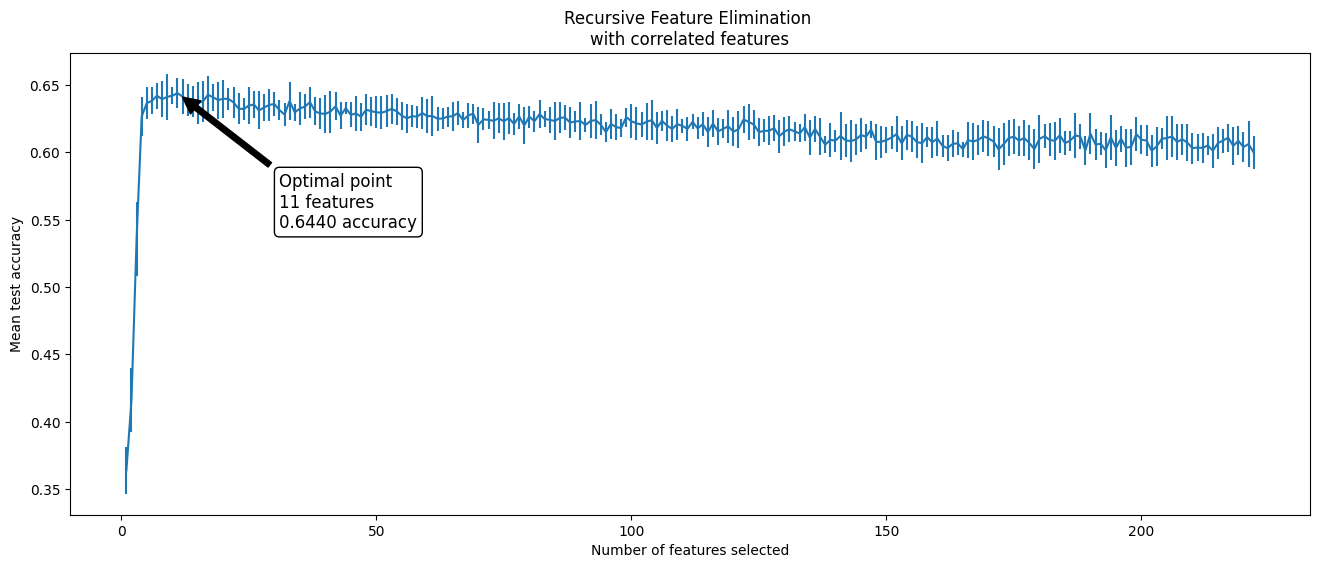

In [43]:
cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure(figsize=(16, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")

# Annotate the optimal point
optimal_idx = rfecv.n_features_ - 1
optimal_n_features = cv_results["n_features"][optimal_idx]
optimal_score = cv_results["mean_test_score"][optimal_idx]
plt.annotate(
    f'Optimal point\n{optimal_n_features} features\n{optimal_score:.4f} accuracy',
    xy=(optimal_n_features, optimal_score),
    xytext=(optimal_n_features + 20, optimal_score - 0.1),
    arrowprops=dict(facecolor='black', shrink=0.05),
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
)

plt.show()

In [44]:
scores

array([0.55972696, 0.5969257 , 0.59607173, 0.59180188, 0.58753202])

In [58]:
# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Dictionary to save all metrics
all_metrics = {}

# Define the models you want to test
models = {
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'LogisticRegression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
}

# Loop through each model to evaluate on the reduced feature set
for model_name, model in models.items():
    print(f"\nEvaluating {model_name} on selected features...")

    # Cross-validate the model on the selected features and calculate accuracy
    cv_scores = cross_val_score(model, 
                                X_train_selected, 
                                y_train_encoded, 
                                cv=5, 
                                scoring='accuracy', 
                                n_jobs=-1)
    
    # Fit the model on the full training set with selected features and make predictions
    model.fit(X_train_selected, y_train_encoded)
    y_pred_encoded = model.predict(X_test_selected)
    
    # Decode predictions back to original labels
    y_pred = label_encoder.inverse_transform(y_pred_encoded)

    # Generate a classification report and parse it into a dictionary
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store the results in the dictionary
    all_metrics[model_name] = {
        'cv_mean_accuracy': np.mean(cv_scores),
        'cv_std_accuracy': np.std(cv_scores),
        'classification_report': report
    }

    # Print the metrics
    print(f"Cross-validated accuracy for {model_name}: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

# all_metrics now contains all model performance metrics
print("\nAll Metrics Summary:")
for model, metrics in all_metrics.items():
    print(f"\nModel: {model}")
    print(f"Cross-Validated Accuracy: {metrics['cv_mean_accuracy']:.4f} (+/- {metrics['cv_std_accuracy']:.4f})")
    print("Classification Report:")
    for label, values in metrics['classification_report'].items():
        print(f"{label}: {values}")


Evaluating RandomForest on selected features...


Cross-validated accuracy for RandomForest: 0.6431 (+/- 0.0124)

Classification Report for RandomForest:
              precision    recall  f1-score   support

           A       0.64      0.70      0.67       437
           D       0.53      0.19      0.28       354
           H       0.66      0.85      0.74       673

    accuracy                           0.64      1464
   macro avg       0.61      0.58      0.56      1464
weighted avg       0.62      0.64      0.61      1464


Evaluating LogisticRegression on selected features...
Cross-validated accuracy for LogisticRegression: 0.6096 (+/- 0.0128)

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           A       0.64      0.70      0.67       437
           D       0.36      0.38      0.37       354
           H       0.75      0.68      0.72       673

    accuracy                           0.61      1464
   macro avg       0.58      0.59      0.58      1464
weighted avg      

In [59]:
scores = pd.DataFrame(all_metrics)
scores

,RandomForest,LogisticRegression,XGBoost
cv_mean_accuracy,0.643103,0.609633,0.633199
cv_std_accuracy,0.012402,0.012753,0.008934
classification_report,"{'A': {'precision': 0.6395833333333333, 'recal...","{'A': {'precision': 0.6380753138075314, 'recal...","{'A': {'precision': 0.6466666666666666, 'recal..."


In [61]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Create XGBoost classifier
xgb = XGBClassifier()

# Perform GridSearchCV
grid_search = GridSearchCV(xgb, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_selected, y_train_encoded)

# Best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")

Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}


In [62]:
# use the best model
best_model = grid_search.best_estimator_

# Fit the best model on the training data
best_model.fit(X_train_selected, y_train_encoded)

# Make predictions on the test data
y_pred_encoded = best_model.predict(X_test_selected)

# Decode the predictions
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Generate a classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Print the classification report
print("Classification Report for XGBoost:")

print(classification_report(y_test, y_pred))

Classification Report for XGBoost:
              precision    recall  f1-score   support

           A       0.66      0.70      0.68       437
           D       0.58      0.18      0.28       354
           H       0.66      0.87      0.75       673

    accuracy                           0.66      1464
   macro avg       0.63      0.59      0.57      1464
weighted avg       0.64      0.66      0.62      1464



In [67]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', None],
    'bootstrap': [True, False]
}

# Create RandomForest classifier
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1, scoring='accuracy')
random_search.fit(X_train_selected, y_train_encoded)

# Best hyperparameters
print(f"Best hyperparameters: {random_search.best_params_}")

/home/ruifspinto/.local/share/virtualenvs/Premier-League-Football-Rff93ZC3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ruifspinto/.local/share/virtualenvs/Premier-League-Football-Rff93ZC3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ruifspinto/.local/share/virtualenvs/Premier-League-Football-Rff93ZC3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  F

Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'bootstrap': True}


In [69]:
# use the best model
best_model = random_search.best_estimator_

# Fit the best model on the training data
best_model.fit(X_train_selected, y_train_encoded)

# Make predictions on the test data
y_pred_encoded = best_model.predict(X_test_selected)

# Decode the predictions
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Generate a classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Print the classification report
print("Classification Report for RandomForest:")
print(classification_report(y_test, y_pred))

Classification Report for RandomForest:
              precision    recall  f1-score   support

           A       0.66      0.71      0.68       437
           D       0.51      0.23      0.31       354
           H       0.68      0.84      0.75       673

    accuracy                           0.66      1464
   macro avg       0.62      0.59      0.58      1464
weighted avg       0.63      0.66      0.63      1464



In [70]:
# already have pipeline with rfecv want to add to that pipeline the bets model
pipeline.steps.append(('classifier', best_model))

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['day_of_week', 'month', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'home_roll_3_avg_home_total_goals',
       'away_roll_3_avg_home_total_goals', 'home_roll_3_avg_away_total_goals',
       'away_roll_3_avg_away_total_goals',
       ...
       '...
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['home_team', 'away_team'], dtype='object'))])),
                ('feature_selection',
                 RFECV(cv=5,
                       estimator=RandomForestClassifier(class_weight='balanced',
                                                        random_state=42),
                       n_jobs=-1, scoring='accuracy')),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features=None, n_estimators=200,
                                        random_state=42))])

In [71]:
# After fitting the model, access the classifier within the pipeline
classifier = pipeline.named_steps['classifier']

# Get feature importances from the classifier
importances = classifier.feature_importances_

# Access all feature names from the preprocessor
try:
    # Get feature names after preprocessing
    all_feature_names = preprocessor.get_feature_names_out()

    # Ensure the length of selected features aligns with preprocessed features
    if len(selected_features) != len(all_feature_names):
        # Align lengths by using only the first part of the names if a mismatch exists
        all_feature_names = all_feature_names[:len(selected_features)]

    # Filter only the selected feature names based on the RFECV selection mask
    selected_feature_names = [all_feature_names[i] for i, is_selected in enumerate(selected_features) if is_selected]
    
    # Combine selected feature names with their importances into a DataFrame
    importance_df = pd.DataFrame({
        'Feature': selected_feature_names,
        'Importance': importances
    })

    # Sort by importance (from highest to lowest)
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Display the sorted importance DataFrame
    print("\nFeature Importances of Selected Features:")
    display(importance_df)
    
except AttributeError:
    print("\nCould not retrieve feature names. Ensure the preprocessor is a ColumnTransformer with feature names available.")


Feature Importances of Selected Features:


,Feature,Importance
9,num__home_cumulative_points,0.200708
10,num__away_cumulative_points,0.165119
5,num__away_roll_3_avg_home_fouls_to_away_fouls,0.077013
1,num__away_roll_3_avg_home_shot_accuracy,0.076721
4,num__home_roll_3_avg_home_fouls_to_away_fouls,0.074633
0,num__home_roll_3_avg_home_shot_accuracy,0.073810
6,num__home_roll_3_avg_away_shots_to_home_shots,0.073375
3,num__away_roll_3_avg_home_shots_to_away_shots,0.066399
8,num__home_roll_5_avg_home_shots_to_away_shots,0.065212
7,num__away_roll_3_avg_away_shots_to_home_shots,0.063645


In [72]:
# saving the model
import joblib

# Save the model as a pickle file
filename = os.path.join('..','models','football_model.pkl')
joblib.dump(pipeline, filename)

['../models/football_model.pkl']

In [73]:
# Save X_test and y_test as csv files
X_test.to_csv(os.path.join('..','data','processed','X_test.csv'), index=False)
y_test.to_csv(os.path.join('..','data','processed','y_test.csv'), index=False)
data_for_back_testing.to_csv(os.path.join('..','data','processed','data_for_back_testing.csv'), index=False)